In [11]:
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel
from scipy.spatial import KDTree
from scipy.linalg import sqrtm

In [26]:
p = 3
n = 5000
# locations of observations (1x1 square domain)
s = np.random.rand(n,2)

In [76]:
import numpy as np
from scipy.spatial.distance import pdist, squareform

def matern_correlation(distances, nu, length_scale):
    """
    Calculates the Matern correlation function.

    Args:
        distances (np.ndarray): A 1D array of distances between points.
        nu (float): The smoothness parameter of the Matern kernel.
                    Common values are 0.5, 1.5, 2.5, or infinity (for RBF kernel).
        length_scale (float): The characteristic length scale of the correlation.

    Returns:
        np.ndarray: A 1D array of Matern correlation values.
    """
    if nu == 0.5:
        # Exponential kernel (Matern with nu=0.5)
        return np.exp(-distances / length_scale)
    elif nu == 1.5:
        # Matern with nu=1.5
        scaled_dist = distances / length_scale
        return (1 + np.sqrt(3) * scaled_dist) * np.exp(-np.sqrt(3) * scaled_dist)
    elif nu == 2.5:
        # Matern with nu=2.5
        scaled_dist = distances / length_scale
        return (1 + np.sqrt(5) * scaled_dist + 5/3 * scaled_dist**2) * np.exp(-np.sqrt(5) * scaled_dist)
    elif np.isinf(nu):
        # Radial Basis Function (RBF) or Squared Exponential kernel (Matern with nu=infinity)
        return np.exp(-0.5 * (distances / length_scale)**2)
    else:
        # General Matern kernel (requires special functions from scipy.special)
        from scipy.special import kv, gamma
        scaled_dist = distances / length_scale
        # Handle the case where scaled_dist is zero to avoid division by zero in kv
        # and ensure correlation is 1 at zero distance.
        correlation = np.zeros_like(scaled_dist)
        non_zero_indices = scaled_dist > 1e-10 # Small epsilon to avoid exact zero
        
        correlation[non_zero_indices] = (2**(1-nu) / gamma(nu)) * \
                                        (np.sqrt(2*nu) * scaled_dist[non_zero_indices])**nu * \
                                        kv(nu, np.sqrt(2*nu) * scaled_dist[non_zero_indices])
        correlation[~non_zero_indices] = 1.0 # Correlation is 1 at zero distance
        return correlation

# Calculate pairwise distances between points
distances = pdist(s, 'euclidean') # Calculates distances in a condensed form
distance_matrix = squareform(distances) # Converts to a square matrix

# Set Matern parameters
nu_val = 1.5  # Smoothness parameter
length_scale_val = 0.25 # Length scale

# Calculate the Matern correlation matrix
matern_corr_matrix = matern_correlation(distance_matrix, nu_val, length_scale_val)

print("Matern Correlation Matrix:")
print(matern_corr_matrix)

Matern Correlation Matrix:
[[1.         0.05487874 0.05405888 ... 0.72568374 0.02191063 0.49652673]
 [0.05487874 1.         0.89353847 ... 0.02804267 0.01502165 0.07376868]
 [0.05405888 0.89353847 1.         ... 0.02614106 0.02283767 0.06177732]
 ...
 [0.72568374 0.02804267 0.02614106 ... 1.         0.01001638 0.50536809]
 [0.02191063 0.01502165 0.02283767 ... 0.01001638 1.         0.00671457]
 [0.49652673 0.07376868 0.06177732 ... 0.50536809 0.00671457 1.        ]]


In [77]:
#K = rbf_kernel(s, s, gamma=1) + 1e-6*np.eye(n)
z = np.random.multivariate_normal(np.zeros(n), matern_corr_matrix, p)

# center the data:
z = z - z.mean(axis=1)[:, np.newaxis]

In [79]:
# mixing matrix
O = np.random.normal(size=(p,p))
x = O @ z

# whiten so that SOBIsym works
W = np.linalg.inv(sqrtm(np.cov(x)))
xt = W @ x

In [80]:
# xt is whitened
np.cov(xt)

array([[ 1.00000000e+00, -1.82646012e-16, -2.97066277e-16],
       [-1.82646012e-16,  1.00000000e+00, -1.47182837e-15],
       [-2.97066277e-16, -1.47182837e-15,  1.00000000e+00]])

In [82]:
def calculate_local_covariance(points, radius, variables):
    """
    Calculates the covariance matrix for points within a certain radius for each point.

    Args:
        points (np.ndarray): A NumPy array of shape (N, D) where N is the number of
                             points and D is the dimension (e.g., 3 for 3D points).
        radius (float): The radius within which to search for neighbors.
        variables (np.ndarray): a NumPy array of shape (N, P) where P is the dimension
                            of the variables

    Returns:
        np.ndarray: PxP matrix of the covariance
    """
    # Build a KD-Tree for efficient spatial searching
    tree = KDTree(points)
    
    # List to store the covariance matrix for each point
    covariance_matrix = np.zeros((variables.shape[1], variables.shape[1]))
    
    # Iterate over each point
    for i, query_point in enumerate(points):
        # Find indices of points within the specified radius
        # search_radius_vector_3d (as mentioned in Open3D docs) has a similar KDTree method in scipy
        neighbor_indices = tree.query_ball_point(query_point, radius)
        
        # Select the neighboring points
        neighbors = variables[neighbor_indices]
        
        covariance_matrix += np.einsum('ij, ik -> jk', neighbors, neighbors)
            
    return covariance_matrix / variables.shape[0]

In [83]:
# calculate local covariance matrices
M01 = calculate_local_covariance(s, 0.5, xt.T)
M005 = calculate_local_covariance(s, 0.2, xt.T)
M0025 = calculate_local_covariance(s, 0.05, xt.T)
M001 = calculate_local_covariance(s, 0.01, xt.T)
M = np.stack((M01, M005, M0025, M001), axis=1)

In [84]:
M.shape

(3, 4, 3)

In [85]:
M

array([[[ 2.52564325e+03, -1.67744846e+01, -1.35502532e+02],
        [ 5.27453277e+02, -9.35812855e+00, -1.59328519e+01],
        [ 3.82843980e+01, -7.46684539e-01, -2.38509755e-01],
        [ 2.57126468e+00,  2.26653440e-02,  2.23340893e-02]],

       [[-1.67744846e+01,  2.20044709e+03, -2.43517811e+01],
        [-9.35812855e+00,  5.02454879e+02, -6.11910964e+00],
        [-7.46684539e-01,  3.86438139e+01, -3.32792648e-01],
        [ 2.26653440e-02,  2.57716092e+00,  8.19596540e-03]],

       [[-1.35502532e+02, -2.43517811e+01,  2.36593225e+03],
        [-1.59328519e+01, -6.11910964e+00,  5.15859390e+02],
        [-2.38509755e-01, -3.32792648e-01,  3.80864917e+01],
        [ 2.23340893e-02,  8.19596540e-03,  2.49176055e+00]]])

In [86]:
def H(g, S):
    # shape of S (p,k,p)
    return np.tensordot(g, S, axes=([0],[0])) @ g @ (S @ g).T

In [87]:
G = np.eye(p)
for i in range(5000):
    for j in range(p):
        G[j,:] = H(G[j,:], M)
    # orthogonalize
    U, Sigma, V = np.linalg.svd(G)
    G = U @ V.T

In [88]:
# off-diagonals are minimized
G @ M01 @ G.T, G @ M005 @ G.T, G @ M0025 @ G.T, G @ M001 @ G.T

(array([[2506.85066696,  -21.74279127, -140.73499071],
        [ -21.74279127, 2193.13234667,   14.24826591],
        [-140.73499071,   14.24826591, 2392.03958067]]),
 array([[530.8858378 ,  -2.60245632, -11.83108584],
        [ -2.60245632, 497.89097617,  10.68677001],
        [-11.83108584,  10.68677001, 516.99073133]]),
 array([[ 3.83188898e+01,  1.63834843e-02, -3.63049999e-02],
        [ 1.63834843e-02,  3.82678106e+01,  8.92591111e-01],
        [-3.63049999e-02,  8.92591111e-01,  3.84280032e+01]]),
 array([[ 2.4961933 ,  0.02585519, -0.02028596],
        [ 0.02585519,  2.58003106, -0.01716337],
        [-0.02028596, -0.01716337,  2.56396179]]))

In [89]:
# calculate local covariance matrices
M01 = calculate_local_covariance(s, 0.5, x.T)
M005 = calculate_local_covariance(s, 0.2, x.T)
M0025 = calculate_local_covariance(s, 0.05, x.T)
M001 = calculate_local_covariance(s, 0.01, x.T)
M = np.stack((M01, M005, M0025, M001), axis=1)

In [90]:
G @ W @ M01 @ W.T @ G.T, G @ W @ M005 @ W.T @ G.T, G @ W @ M0025 @ W.T @ G.T, G @ W @ M001 @ W.T @ G.T

(array([[2506.85066696,  -21.74279127, -140.73499071],
        [ -21.74279127, 2193.13234667,   14.24826591],
        [-140.73499071,   14.24826591, 2392.03958067]]),
 array([[530.8858378 ,  -2.60245632, -11.83108584],
        [ -2.60245632, 497.89097617,  10.68677001],
        [-11.83108584,  10.68677001, 516.99073133]]),
 array([[ 3.83188898e+01,  1.63834843e-02, -3.63049999e-02],
        [ 1.63834843e-02,  3.82678106e+01,  8.92591111e-01],
        [-3.63049999e-02,  8.92591111e-01,  3.84280032e+01]]),
 array([[ 2.4961933 ,  0.02585519, -0.02028596],
        [ 0.02585519,  2.58003106, -0.01716337],
        [-0.02028596, -0.01716337,  2.56396179]]))

In [91]:
# G is orthogonal
G @ G.T

array([[ 1.00000000e+00, -3.81988624e-16, -3.91839381e-16],
       [-3.81988624e-16,  1.00000000e+00,  4.33250167e-16],
       [-3.91839381e-16,  4.33250167e-16,  1.00000000e+00]])

In [48]:
G = G @ W

In [92]:
from scipy.optimize import linear_sum_assignment

def MDI(G):
    Gt = G**2 / (np.linalg.norm(G, axis=1)**2)[:, np.newaxis]
    cost = np.ones_like(Gt) - 2*Gt - (Gt**2).sum(axis=1)[:, np.newaxis]
    row_ind, col_ind = linear_sum_assignment(cost, maximize=False)
    perm = np.argsort(col_ind)
    return (G.shape[0] - (Gt[row_ind, col_ind]).sum())**0.5 / (G.shape[0] - 1)**0.5

In [93]:
MDI(G @ W @ O)

np.float64(0.6382238490853975)

In [69]:
G @ O, G @ W @ O, G @ np.linalg.inv(W) @ O

(array([[-0.26516926,  0.44100735,  1.01881955],
        [-0.85730281,  0.6742671 ,  0.06079992],
        [ 0.11061135, -0.05110238, -0.24197733]]),
 array([[ 0.21333725,  0.28764856,  1.10680401],
        [-1.02841817,  0.70603531, -0.44881716],
        [ 0.55669072,  0.48609974, -0.64336904]]),
 array([[-0.58216911,  0.67455515,  1.04410009],
        [-0.84504296,  0.74509114,  0.43740802],
        [ 0.13051869, -0.14063042, -0.21907333]]))

In [52]:
r,c = MDI(G @ (W @ O))
A = G @ (W @ O)[np.argsort(c)] 
A @ np.diag(1/np.diag(A))

TypeError: cannot unpack non-iterable numpy.float64 object

In [23]:
((X / np.linalg.norm(X, axis=1)[:, np.newaxis])**2).sum(axis=1)

array([1., 1., 1.])

In [143]:
G @ G.T

array([[1.00000000e+00, 2.04184287e-16, 1.10684422e-16],
       [2.04184287e-16, 1.00000000e+00, 2.54946770e-17],
       [1.10684422e-16, 2.54946770e-17, 1.00000000e+00]])

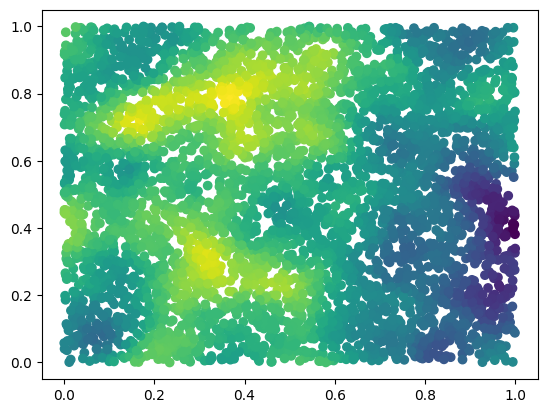

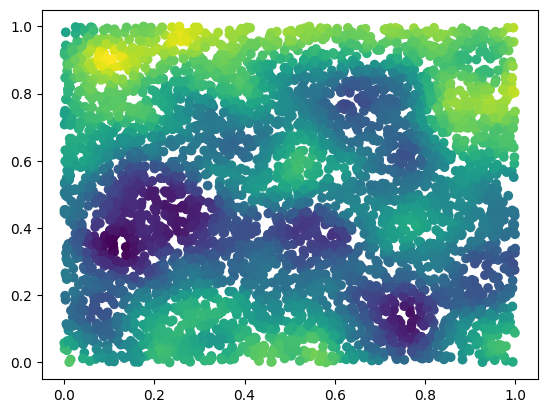

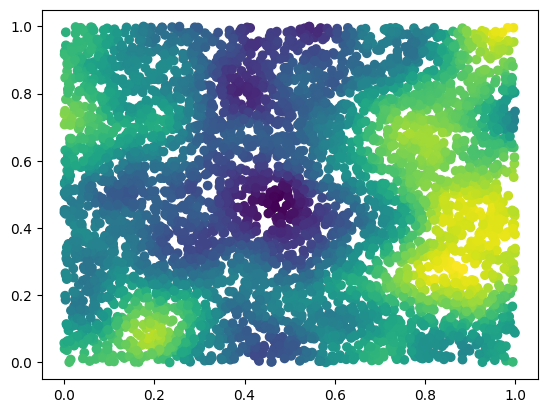

In [78]:
import matplotlib.pyplot as plt
plt.scatter(s.T[0], s.T[1], c = z[0])
plt.show()
plt.scatter(s.T[0], s.T[1], c = z[1])
plt.show()
plt.scatter(s.T[0], s.T[1], c = z[2])
plt.show()

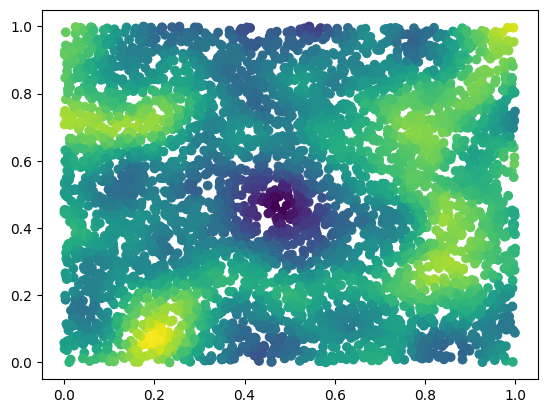

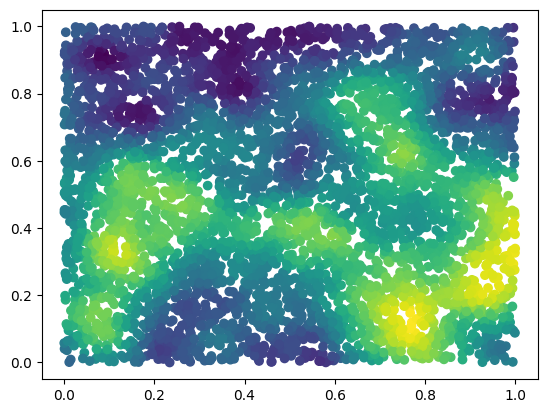

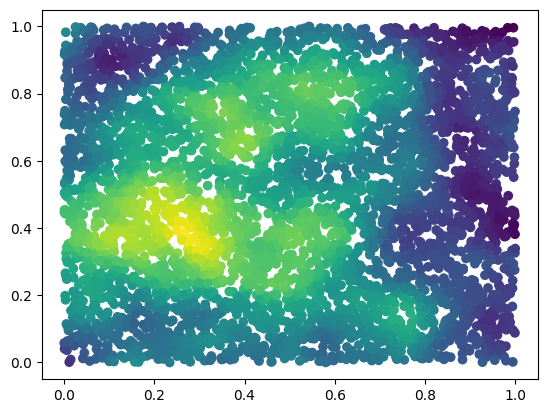

In [81]:
plt.scatter(s.T[0], s.T[1], c = x[0])
plt.show()
plt.scatter(s.T[0], s.T[1], c = x[1])
plt.show()
plt.scatter(s.T[0], s.T[1], c = x[2])
plt.show()

In [55]:
O

array([[ 0.88612786, -0.78239732, -0.40480609],
       [-0.14833105,  0.14365404,  0.50107971],
       [ 0.10145457,  0.13766992,  0.82782492]])